<a href="https://colab.research.google.com/github/jadercaro/Prediccion-de-desercion-universitaria/blob/main/2_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importamos las librerías

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')
!git clone https://github.com/jadercaro/Prediccion-de-desercion-universitaria
os.chdir('/content/Prediccion-de-desercion-universitaria/dataset')


Cargamos la base de datos

In [ ]:
df_train = pd.read_csv('data_train.csv')
df_test = pd.read_csv('data_test.csv')

#Separamos las variables independientes de la variable objetivo
x_train = df_train.drop(columns='Target')
y_train = df_train['Target']

#Separamos las variables independiente de la variable objetivo
x_test = df_test.drop(columns='Target')
y_test = df_test['Target']

# Modelamientos

## Boosting Gradient Classifier
Para este modelo usaremos un GridSearch para seleccionar los mejores hiperparámetros

In [ ]:
parametros = {'loss':['log_loss', 'exponential'],
              'learning_rate':[0.1, 0.3, 0.7, 1],
              'n_estimators':[50,80, 100, 120],
              'subsample':[0.1, 0.5, 0.8, 1],
              'criterion':['friedman_mse', 'squared_error'],
              'max_features': ['sqrt', 'log2'],
              'ccp_alpha':[0,0.1,0.3]}

gb = GradientBoostingClassifier()

scoring = ['roc_auc', 'f1','recall','precision']

In [ ]:
grid_gbc = GridSearchCV(estimator=gb,
                   param_grid=parametros,
                   scoring=scoring,
                   cv = 5,
                   verbose = 1000,
                   refit=False)

grid_gbc.fit(x_train, y_train)

### Resultados del Boosting Gradient Classifier

In [ ]:
resultados = pd.DataFrame(grid_gbc.cv_results_)
resultados = resultados.sort_values(by='mean_test_f1', ascending=False)
resultados[['mean_test_roc_auc','std_test_roc_auc','mean_test_f1','std_test_f1','mean_test_recall', 'std_test_recall',
          'mean_test_precision', 'std_test_precision']].head(3)

,mean_test_roc_auc,std_test_roc_auc,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall,mean_test_precision,std_test_precision
363,0.951615,0.006358,0.891779,0.004171,0.866307,0.012687,0.919071,0.010145
111,0.953464,0.004252,0.891537,0.010171,0.861033,0.020987,0.924827,0.014002
367,0.955425,0.005290,0.890322,0.003669,0.860155,0.011279,0.923075,0.015420


### Parámetros obtenidos Boosting Gradient Classifier

In [ ]:
resultados[['param_ccp_alpha', 'param_criterion', 'param_learning_rate',
       'param_loss', 'param_max_features', 'param_n_estimators',
       'param_subsample']].head(5)

,param_ccp_alpha,param_criterion,param_learning_rate,param_loss,param_max_features,param_n_estimators,param_subsample
363,0,squared_error,0.3,exponential,sqrt,100,1
111,0,friedman_mse,0.3,exponential,sqrt,120,1
367,0,squared_error,0.3,exponential,sqrt,120,1
330,0,squared_error,0.3,log_loss,sqrt,100,0.8
335,0,squared_error,0.3,log_loss,sqrt,120,1


### Validamos el modelo obtenido

In [ ]:
gbc = GradientBoostingClassifier(ccp_alpha=0,
                                 criterion='squared_error',
                                 learning_rate=0.3,
                                 loss='exponential',
                                 max_features='sqrt',
                                 n_estimators=120,
                                 subsample=1)

gbc.fit(x_train, y_train)

GradientBoostingClassifier(ccp_alpha=0, criterion='squared_error',
                           learning_rate=0.3, loss='exponential',
                           max_features='sqrt', n_estimators=120, subsample=1)

### Matriz de confusión - Boosting Gradient Classifier

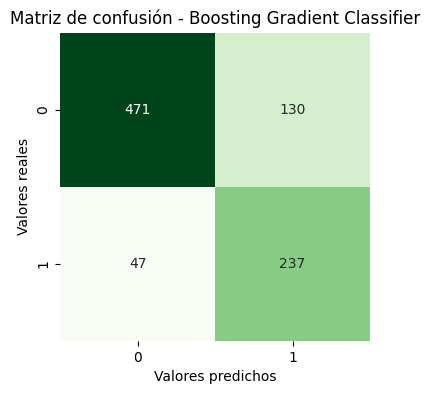

In [ ]:
y_pred=gbc.predict(x_test)

#Creamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficamos la matriz
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión - Boosting Gradient Classifier')
plt.show()

In [ ]:
resultados_gbc = pd.DataFrame({"Recall":[recall_score(y_test,y_pred)],
                               "Precision":[precision_score(y_test,y_pred)],
                               "F1-Score":[f1_score(y_test, y_pred)]})

resultados_gbc

,Recall,Precision,F1-Score
0,0.834507,0.645777,0.728111


### Curva ROC - Boosting Gradient Classifier

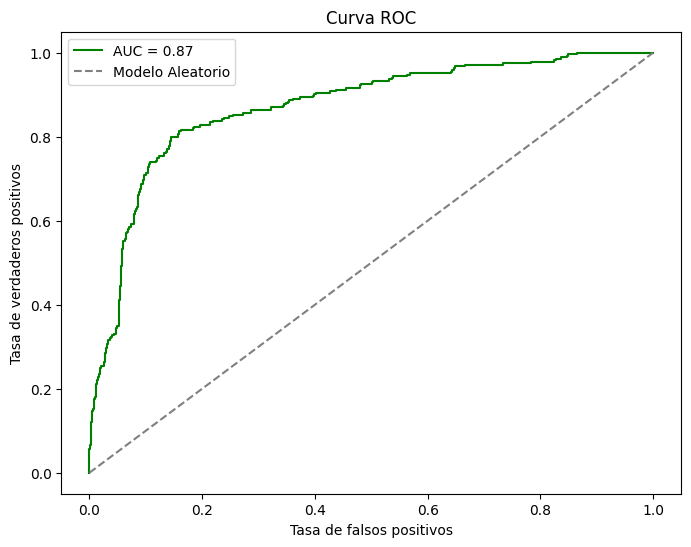

In [ ]:
y_prob = gbc.predict_proba(x_test)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])

# Calcular el AUC-ROC
auc = roc_auc_score(y_test, y_prob[:, 1])

# Graficamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='g')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Modelo Aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

## Random Forest Classifier

In [ ]:
parametros = {'n_estimators':[20,50,80,100,120],
              'criterion':['gini','entropy','log_loss'],
              'ccp_alpha':[0,0.05,0.1,0.2],
              'max_depth':[None, 10, 15],
              'max_features':[None,'sqr','log2'],
              'random_state':[6789]}

rf = RandomForestClassifier()

In [ ]:
grid_rf = GridSearchCV(estimator=rf,
                   param_grid=parametros,
                   scoring=scoring,
                   cv = 5,
                   verbose = 100,
                   refit=False)

model_rf=grid_rf.fit(x_train, y_train)

###Resultados Random Forest

In [ ]:
resultados_rf = pd.DataFrame(grid_rf.cv_results_)

resultados_rf = resultados_rf.sort_values(by='mean_test_recall', ascending=False)
resultados_rf[['mean_test_roc_auc','std_test_roc_auc','mean_test_f1','std_test_f1','mean_test_recall', 'std_test_recall',
          'mean_test_precision', 'std_test_precision']].head(5)

,mean_test_roc_auc,std_test_roc_auc,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall,mean_test_precision,std_test_precision
3,0.954330,0.005086,0.883433,0.009842,0.849594,0.012042,0.920398,0.018289
34,0.953526,0.003697,0.884175,0.014079,0.848713,0.016001,0.923311,0.025952
2,0.952442,0.004621,0.882913,0.015055,0.847851,0.010903,0.921332,0.026012
94,0.956544,0.003931,0.886928,0.012968,0.847851,0.011254,0.930059,0.021820
4,0.951760,0.004887,0.882828,0.015837,0.847844,0.015423,0.921056,0.021954


### Parámetros obtenidos Random forest

In [ ]:
resultados_rf[['param_ccp_alpha', 'param_criterion', 'param_max_depth',
       'param_max_features', 'param_n_estimators']].head(5)

,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_n_estimators
3,0,gini,None,None,100
34,0,gini,15,None,120
2,0,gini,None,None,80
94,0,log_loss,None,None,120
4,0,gini,None,None,120


### Validamos el modelo obtenido

In [ ]:
rf = RandomForestClassifier(ccp_alpha=0,
                            criterion='gini',
                            max_depth=None,
                            max_features=None,
                            n_estimators=80,
                            random_state=6789)

modelo_rf=rf.fit(x_train, y_train)

RandomForestClassifier(ccp_alpha=0, max_features=None, n_estimators=80,
                       random_state=6789)

### Matriz de confusión - Regresión logistica

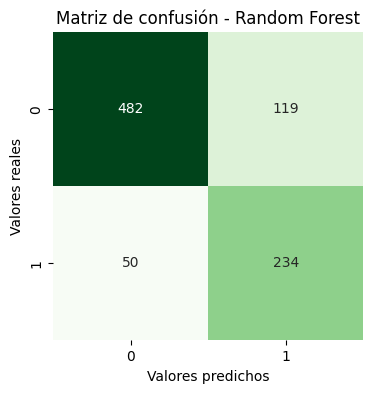

In [ ]:
y_pred=modelo_rf.predict(x_test)

#Creamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficamos la matriz
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión - Random Forest')
plt.show()

In [ ]:
resultados_rf = pd.DataFrame({"Recall":[recall_score(y_test,y_pred)],
                               "Precision":[precision_score(y_test,y_pred)],
                               "F1-Score":[f1_score(y_test, y_pred)]})

resultados_rf

,Recall,Precision,F1-Score
0,0.823944,0.66289,0.734694


###Curva ROC - Random Forest

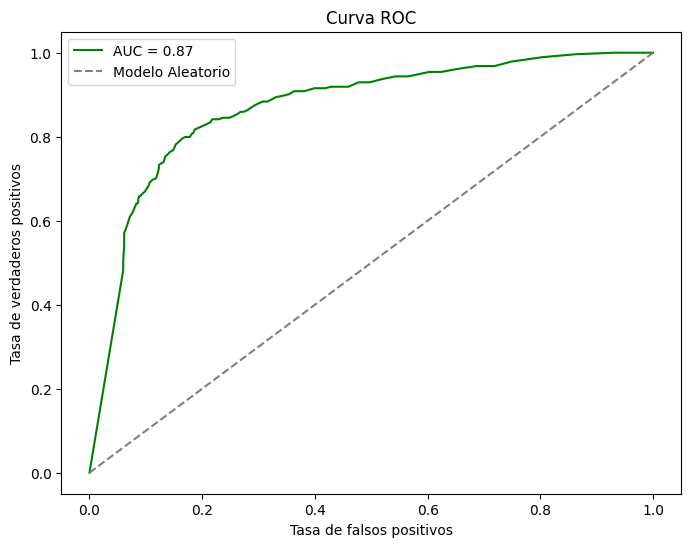

In [ ]:
y_prob = modelo_rf.predict_proba(x_test)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])

# Calcular el AUC-ROC
auc = roc_auc_score(y_test, y_prob[:, 1])

# Graficamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='g')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Modelo Aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

## Regresión Logistica

In [ ]:
parametros = {'penalty':['l1','l2',None, 'elasticnet'],
              'C':[0.5,0.8,1, 1.2, 1.5],
              'solver':['saga'],
              'tol':[0.0001,0.001,0.01,0.1,1],
              'max_iter':[100,500,1000,1500,3000],
              'random_state':[6789]}

lr = LogisticRegression()

In [ ]:
grid_lr = GridSearchCV(estimator=lr,
                   param_grid=parametros,
                   scoring=scoring,
                   cv = 5,
                   verbose = 1000,
                   refit=False)

grid_lr.fit(x_train, y_train)

### Resultados Regresión Logistica

In [ ]:
resultados_lr = pd.DataFrame(grid_lr.cv_results_)

resultados_lr = resultados_lr.sort_values(by='mean_test_recall', ascending=False)
resultados_lr[['mean_test_roc_auc','std_test_roc_auc','mean_test_f1','std_test_f1','mean_test_recall', 'std_test_recall',
          'mean_test_precision', 'std_test_precision']].head(5)

,mean_test_roc_auc,std_test_roc_auc,mean_test_f1,std_test_f1,mean_test_recall,std_test_recall,mean_test_precision,std_test_precision
405,0.953072,0.005857,0.891935,0.007059,0.868066,0.022105,0.917991,0.017278
406,0.953072,0.005857,0.891935,0.007059,0.868066,0.022105,0.917991,0.017278
305,0.953224,0.005857,0.891926,0.007774,0.868066,0.022105,0.917906,0.016141
306,0.953224,0.005857,0.891926,0.007774,0.868066,0.022105,0.917906,0.016141
126,0.953449,0.005842,0.891896,0.007614,0.868062,0.023479,0.917897,0.015258


### Parámetros obtenidos Regresión Logistica

In [ ]:
resultados_lr[['param_C', 'param_max_iter', 'param_penalty', 'param_tol']].head(5)

,param_C,param_max_iter,param_penalty,param_tol
405,1.5,100,l2,0.0001
406,1.5,100,l2,0.001
305,1.2,100,l2,0.0001
306,1.2,100,l2,0.001
126,0.8,500,l2,0.001


### Validamos el modelo obtenido

In [ ]:
lr = LogisticRegression(penalty='l2',
                        C=1.5,
                        max_iter=100,
                        random_state=6789,
                        solver='saga',
                        tol=0.0001)

modelo_lr = lr.fit(x_train, y_train)

### Matriz de confusión - Regresión logistica

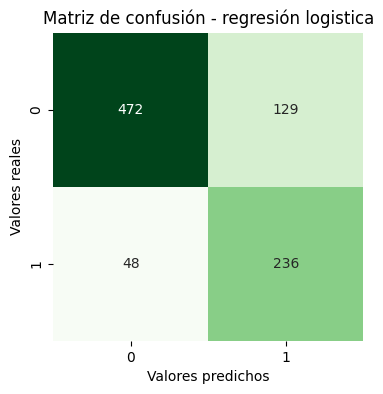

In [ ]:
y_pred=modelo_lr.predict(x_test)

#Creamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficamos la matriz
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Valores predichos')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión - regresión logistica')
plt.show()

In [ ]:
resultados_lr = pd.DataFrame({"Recall":[recall_score(y_test,y_pred)],
                               "Precision":[precision_score(y_test,y_pred)],
                               "F1-Score":[f1_score(y_test, y_pred)]})

resultados_lr

,Recall,Precision,F1-Score
0,0.830986,0.646575,0.727273


### Curva ROC - Regresión Logistica

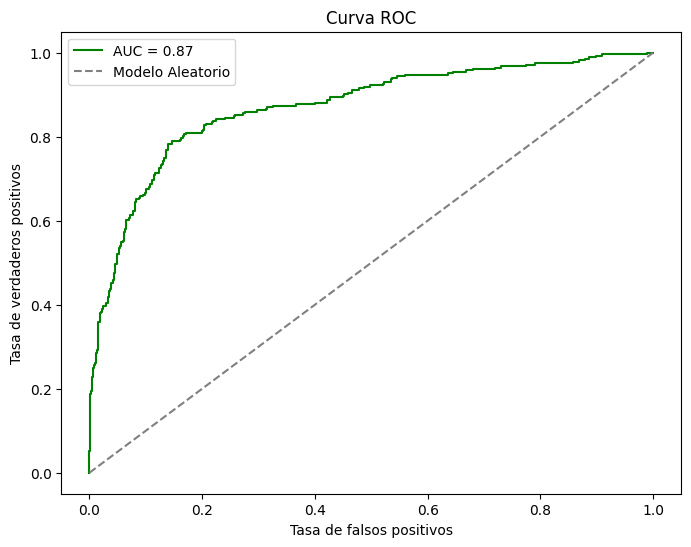

In [ ]:
y_prob = modelo_lr.predict_proba(x_test)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])

# Calcular el AUC-ROC
auc = roc_auc_score(y_test, y_prob[:, 1])

# Graficamos la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', color='g')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Modelo Aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [ ]:
coeficientes = modelo_lr.coef_[0]

# Obtener el nombre de las características
nombres_caracteristicas = list(x_train.columns)  # Suponiendo que las características tienen nombres

# Crear un DataFrame para visualizar los coeficientes
tabla_coeficientes = pd.DataFrame({'Característica': nombres_caracteristicas, 'Coeficiente': coeficientes})

# Ordenar la tabla de coeficientes por valor absoluto de los coeficientes
tabla_coeficientes['Coeficiente_abs'] = tabla_coeficientes['Coeficiente'].abs()
tabla_coeficientes = tabla_coeficientes.sort_values(by='Coeficiente_abs', ascending=False).drop('Coeficiente_abs', axis=1)

# Visualizar las características con los mayores coeficientes en valor absoluto
print(tabla_coeficientes.head(40))

                             Característica  Coeficiente
4                   Tuition fees up to date    -2.585557
13         Curricular units 2nd sem (grade)    -1.988951
8       Curricular units 1st sem (approved)    -1.873295
147                   Mother's occupation_0     1.429395
3                                    Debtor     1.359699
65                              Course_9853     1.196832
102               Mother's qualification_34     1.170755
36                      Application mode_42     1.054280
78                Previous qualification_19     1.030557
39                      Application mode_51     0.967202
57                              Course_9130     0.924556
136               Father's qualification_34     0.911444
158                  Mother's occupation_90     0.905941
18                         Marital status_1     0.878817
52                              Course_8014    -0.868477
63                              Course_9670     0.834193
59                             